<a href="https://colab.research.google.com/github/curtcorum/mri_8ch_simulator_corrected_k_scaling_py/blob/main/mri_8ch_simulator_corrected_k_scaling_py.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Here is the updated notebook.

I have restored the **8-channel ring configuration** while preserving the **corrected scaling logic** (using `matrix_size` and `dk` scaling). This ensures the object sizing is correct while simulating the localized sensitivity profiles of a phased array coil.

### Colab-Ready Notebook

Checking for GPU...
No GPU. Using NumPy.
Setting up Cartesian Grid...
Running 8-Channel Simulation...
Reconstructing (Sum of Squares)...


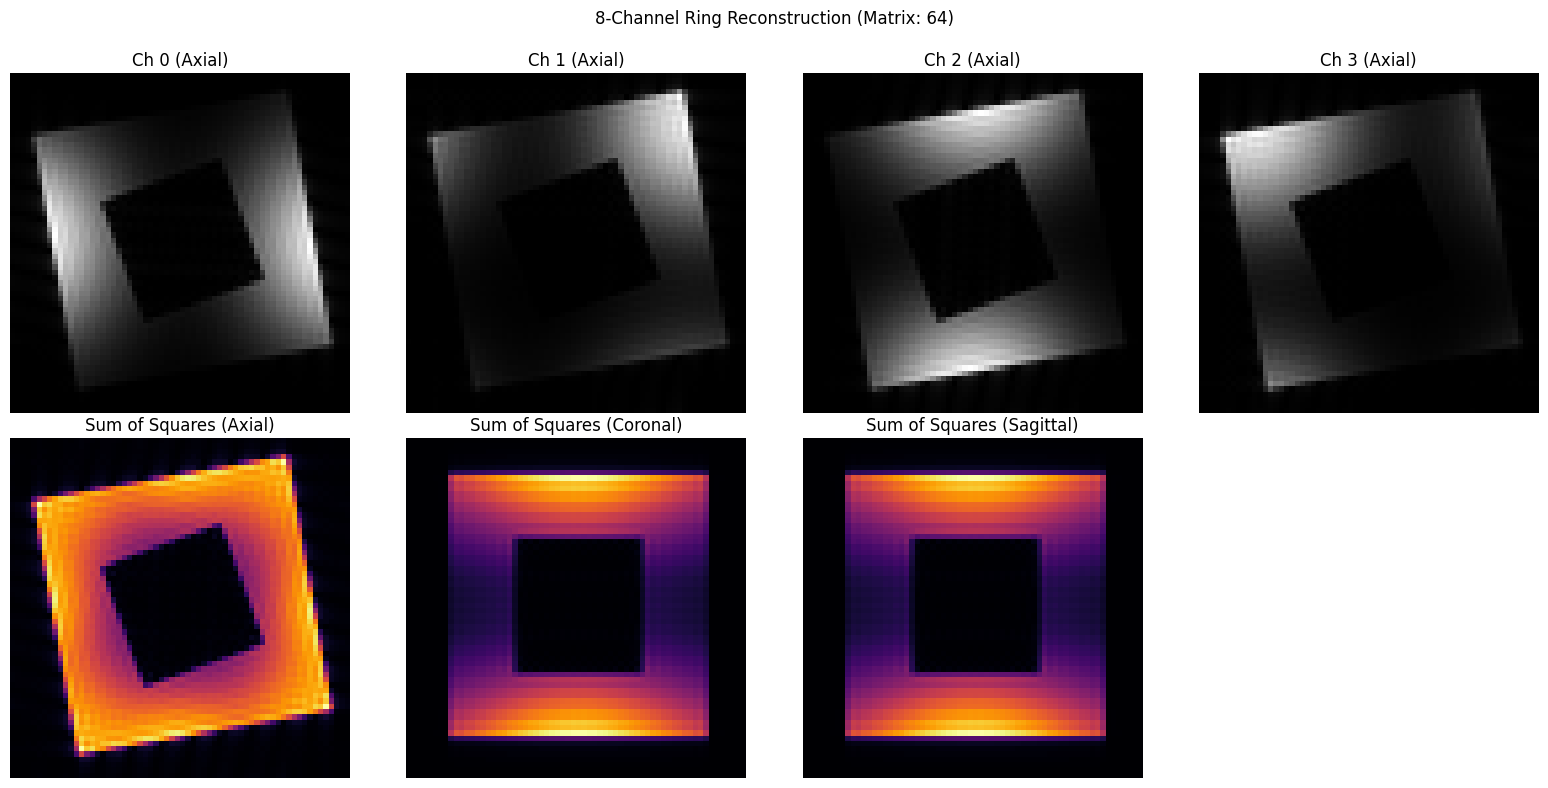

In [ ]:
# @title 8-Channel Ring Simulation (Corrected Scaling)
# @markdown Run this cell to simulate an 8-channel coil ring with proper k-space scaling.

import sys
import subprocess
import numpy as np
import matplotlib.pyplot as plt

# 1. Environment Setup
try:
    import cupy as cp
    HAS_CUPY = True
    print("CuPy is already installed.")
except ImportError:
    print("Checking for GPU...")
    try:
        subprocess.check_output('nvidia-smi')
        print("GPU detected. Installing CuPy...")
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'cupy-cuda12x'])
        import cupy as cp
        HAS_CUPY = True
        print("CuPy installed.")
    except Exception:
        print("No GPU. Using NumPy.")
        import numpy as cp
        HAS_CUPY = False

# --- CLASS DEFINITIONS ---

def Rz(theta):
    c, s = np.cos(theta), np.sin(theta)
    return np.array([[c, -s, 0], [s, c, 0], [0, 0, 1]])

def point_array(N=[3,3,3]):
    """Generates integer offsets centered at 0."""
    Nx, Ny, Nz = N
    Cx, Cy, Cz = (Nx-1)/2, (Ny-1)/2, (Nz-1)/2
    x = (np.arange(Nx)-Cx)
    y = (np.arange(Ny)-Cy)
    z = (np.arange(Nz)-Cz)
    X,Y,Z = np.meshgrid(x,y,z, indexing='ij')
    return np.stack((X,Y,Z), axis=-1)

class CubeObject:
    def __init__(self, gain=1.0, kmax=1.0, L=[.5,.5,.5], D=[0,0,0], R=np.eye(3)):
        self.gain, self.kmax, self.L, self.D, self.R = gain, kmax, L, D, R

    def generate(self, kspace):
        xp = cp if (HAS_CUPY and isinstance(kspace, cp.ndarray)) else np
        k_flat = kspace.reshape(-1, 3)
        L = xp.asarray(self.L); D = xp.asarray(self.D); R = xp.asarray(self.R)

        k_rot = k_flat @ R
        D_rot = D @ R

        # Sinc Arguments (kmax scales [-1,1] to indices)
        argx = 0.5 * self.kmax * k_rot[:,0] * L[0]
        argy = 0.5 * self.kmax * k_rot[:,1] * L[1]
        argz = 0.5 * self.kmax * k_rot[:,2] * L[2]

        ph = xp.sum(0.5 * self.kmax * k_rot * D_rot, axis=1)

        # Note: xp.sinc(x) = sin(pi*x)/(pi*x)
        sig = (self.gain * L[0] * xp.sinc(argx)) * \
              (L[1] * xp.sinc(argy)) * \
              (L[2] * xp.sinc(argz)) * \
              xp.exp(1j * 2 * np.pi * ph)
        return sig.reshape(kspace.shape[:-1])

class GaussianObject:
    def __init__(self, gain=1.0, kmax=1.0, L=[.5,.5,.5], D=[0,0,0]):
        self.gain, self.kmax, self.L, self.D = gain, kmax, L, D

    def generate(self, kspace):
        xp = cp if (HAS_CUPY and isinstance(kspace, cp.ndarray)) else np
        k_flat = kspace.reshape(-1, 3)
        L = xp.asarray(self.L); D = xp.asarray(self.D)

        kx = k_flat[:,0]*L[0]; ky = k_flat[:,1]*L[1]; kz = k_flat[:,2]*L[2]

        scale = 0.5 * self.kmax
        arg_sq = (scale**2) * (kx**2 + ky**2 + kz**2)

        ph = scale * xp.sum(k_flat * D, axis=1)

        return (self.gain * xp.exp(-np.pi*arg_sq) * xp.exp(1j*2*np.pi*ph)).reshape(kspace.shape[:-1])

class MRISimulator:
    def __init__(self, kspace_traj, matrix_size, Nv, nrcvrs=8):
        self.kspaceRad = kspace_traj
        self.matrix_size = matrix_size
        self.Nv = Nv
        self.nrcvrs = nrcvrs

    def run_simulation(self):
        xp = cp if HAS_CUPY else np

        # 1. Grid Scaling
        # Trajectory range is 2.0 (-1 to 1). Pixel spacing = 2.0 / MatrixSize.
        dk = 2.0 / self.matrix_size

        # 2. Coil Kernels Setup
        # Create kernel grid (5x5x5) scaled by dk
        pArray_int = point_array([5,5,5])
        pArray_phys = pArray_int * dk

        pArray_flat = pArray_phys.reshape(-1, 3)
        pArray_gpu = xp.asarray(pArray_flat)

        kernels = xp.zeros((pArray_flat.shape[0], self.nrcvrs), dtype=xp.complex64)

        # --- 8-Channel Ring Setup ---
        # Radius 0.5 (Halfway out to edge of FOV)
        radius = 0.5
        angles = np.linspace(0, 2*np.pi, self.nrcvrs, endpoint=False)

        # Spatial Width L=[1.0, 1.0, 1.0]
        # (Localized sensitivity, unlike the wide 2.0 previously)
        #coil_width = [1.0, 1.0, 1.0]
        coil_width = [0.5, 0.5, 0.75]

        for i in range(self.nrcvrs):
            loc = [radius * np.cos(angles[i]), radius * np.sin(angles[i]), 0.0]

            # Generate Kernel Weights (FT of Spatial Sensitivity)
            # D is positive here; GaussianObject handles phase shift
            kernels[:, i] = GaussianObject(L=coil_width,
                                           kmax=self.matrix_size,
                                           D=loc).generate(pArray_gpu)

            # Normalize
            kernels[:, i] /= xp.sum(xp.abs(kernels[:, i]))

        # 3. Vectorized Convolution
        traj = xp.asarray(self.kspaceRad).reshape(-1, 3)

        # Evaluate Object(k + kernel_offset)
        k_eval = traj[:, None, :] + pArray_gpu[None, :, :]
        k_eval_f = k_eval.reshape(-1, 3)

        # 4. Object Definition
        R_rot = xp.asarray(Rz(np.radians(10)))
        obj_main = CubeObject(gain=100.0, kmax=self.matrix_size, L=[.75,.75,.75], R=R_rot)
        obj_void = CubeObject(gain=-100.0, kmax=self.matrix_size, L=[.37,.37,.37], R=xp.asarray(Rz(np.radians(20))))

        # Signal Generation
        sig = obj_main.generate(k_eval_f) + obj_void.generate(k_eval_f)

        # Apply Channel Weights
        sig_mtrx = sig.reshape(traj.shape[0], pArray_flat.shape[0])
        fid = sig_mtrx @ kernels # (N_traj, nrcvrs)

        return fid.reshape(-1, self.Nv, self.nrcvrs)

# --- TESTING SCRIPT ---

print("Setting up Cartesian Grid...")
matrix_size = 64
kv = np.linspace(-1, 1, matrix_size)
KY, KX, KZ = np.meshgrid(kv, kv, kv, indexing='ij')
grid = np.stack((KX, KY, KZ), axis=-1)

n_total_pts = matrix_size**3
grid_traj = grid.reshape(n_total_pts, 1, 1, 3)

sim = MRISimulator(grid_traj, matrix_size=matrix_size, Nv=1, nrcvrs=8)

print("Running 8-Channel Simulation...")
kdata = sim.run_simulation()

# Reconstruct
if HAS_CUPY: kdata = cp.asnumpy(kdata)
kdata = kdata.reshape(matrix_size, matrix_size, matrix_size, 8)

print("Reconstructing (Sum of Squares)...")
img_sos = np.zeros((matrix_size, matrix_size, matrix_size))
img_channels = []

# Process Channels
for i in range(8):
    k_ch = kdata[..., i]
    img_ch = np.fft.fftshift(np.fft.ifftn(np.fft.ifftshift(k_ch)))
    img_mag = np.abs(img_ch)
    img_channels.append(img_mag)
    img_sos += img_mag**2

img_sos = np.sqrt(img_sos)

# Visualization
center = matrix_size // 2
plt.figure(figsize=(16, 8))

# Plot first 4 channels
for i in range(4):
    plt.subplot(2, 4, i+1)
    plt.imshow(img_channels[i][:, :, center], cmap='gray', origin='lower')
    plt.title(f'Ch {i} (Axial)')
    plt.axis('off')

# Plot SoS Axial
plt.subplot(2, 4, 5)
plt.imshow(img_sos[:, :, center], cmap='inferno', origin='lower')
plt.title('Sum of Squares (Axial)')
plt.axis('off')

# Plot SoS Coronal
plt.subplot(2, 4, 6)
plt.imshow(img_sos[:, center, :], cmap='inferno', origin='lower')
plt.title('Sum of Squares (Coronal)')
plt.axis('off')

# Plot SoS Sagittal
plt.subplot(2, 4, 7)
plt.imshow(img_sos[center, :, :], cmap='inferno', origin='lower')
plt.title('Sum of Squares (Sagittal)')
plt.axis('off')

plt.tight_layout()
plt.suptitle(f'8-Channel Ring Reconstruction (Matrix: {matrix_size})')
plt.subplots_adjust(top=0.9)
plt.show()